In [1]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
pdf_folder = "../data/DSA/Die_Stadt_des_Feuers"
#pdf_folder = "../data/DSA/Adel_Recht_und_Edelmut"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    time.sleep(0.5)
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Die_Stadt_des_Feuers/_combined.pdf
Lade die Datei lokal..



2026-01-25 15:07:17,659 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-25 15:07:17,694 - INFO - Going to convert document batch...
2026-01-25 15:07:17,695 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2026-01-25 15:07:17,699 - INFO - Loading plugin 'docling_defaults'
2026-01-25 15:07:17,704 - INFO - Registered picture descriptions: ['vlm', 'api']
2026-01-25 15:07:17,712 - INFO - Loading plugin 'docling_defaults'
2026-01-25 15:07:17,714 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2026-01-25 15:07:17,715 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2026-01-25 15:07:17,715 - INFO - easyocr cannot be used because it is not installed.
2026-01-25 15:07:17,862 - INFO - Accelerator device: 'cuda:0'
[INFO] 2026-01-25 15:07:17,870 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2026-01-25 15:07:17,884 [RapidOCR] download_file.py:60: 


Anzahl Layout-Spans: 1626


In [2]:
from pipeline_preproc_pdf import process_doc_into_posts 

#Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

#Posts ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

--- Post 1 ---
Die Stadt des Feuers Der Neunaugensee Dunkel breitet sich das sehr tiefe Wasser, das bis an den Horizont im fernen Norden den Himmel berührt. Träge schlagen die Wellen an das Ufer an dem  sich das Schilf im sanften Wind wiest. In der weiten Ferne im glitzernden Wasser ragt majestätisch ein schwarzer Berg aus den Wellen und weißer Rauch steigt von seiner Spitze auf. Fern und doch unheimlich. Das ist Cealan, die verwunschene Insel die jeder Schiffer meidet. Sanfte Hügel und Wälder mit Gehöften und kleinen Dörfern dazwischen erstrecken sich dem gegenüber  ebenso  weit in den Süden. Und dazwischen verläuft die schier endlose Straße 60  Meilen zwischen der geschäftigen Stadt Trallop im Osten und dem  verschlafenen größeren Markt-Dorf Olat mit seiner Grafenburg Olats Feste, am  Rande  des riesigen Nebelmoores im Westen davon. Mehr  als ein Tagesmarsch und die Hälfte davon mit dem  Pferd. Und soweit erstreckt sich auch der Neunaugensee. Viele Sagen und Mythen und Sagen umranken

In [3]:
#Typische DSA-Wörter Pseudonymisieren, zur besseren Identifikation später
from rapidfuzz import fuzz
from nltk.tokenize import word_tokenize
from pathlib import Path

#print(posts[0])
#words = word_tokenize(posts[0], language="german")
#print(words)

for o, post in enumerate(posts): #Iterieren durch alle Posts
    print("Verarbeite Post",o+1,"von",len(posts), end='\r')
    #print_percent_done(o+1,len(posts))
    words = word_tokenize(post, language="german")
    for txt_file in Path("/home/timc/Workspace/nlp-rpg-narratives/").glob("*.txt"): #Iteriere durch alle Text-Files
        txt_file_tokens = str(txt_file).split("/")
        txt_name = txt_file_tokens[-1]
        txt_pseud = txt_name[:-4] #Nutzen den jeweiligen Namen des Text-Files als Pseudonym
        with open(txt_file, "r", encoding="utf-8") as f:
            names = [line.strip() for line in f if line.strip()]
            for name in names: #Iterieren durch alle Namen im jeweiligen Text-File
                for i, word in enumerate(words): #Iterieren durch alle Wörter aus dem jeweiligen Post
                    erg = fuzz.ratio(word, name)
                    if erg > 90.0:
                        words[i] = txt_pseud
                        #print(name,word,txt_pseud)
    posts[o] = ' '.join(words) #Ersetze alten Post in der Liste durch den neuen pseudonymisierten

#print("-----------------------------------------------------------")
#print(words)
#posts[0] = ' '.join(words)
#print(posts[0])


In [4]:
from pipeline_preproc_lemma import TextPreprocessingPipeline #Posts von Satzzeichen und Ziffern bereinigen & anschließend lemmatisieren 

pipeline = TextPreprocessingPipeline()
posts_clean = pipeline.process_posts(posts, debug=False) #debug für print-Ausgaben der Zwischenschritte

#Posts ausgeben
for i, p in enumerate(posts_clean):
    print(f"--- Post {i+1} ---\n{p}\n")

Lade spaCy-Modell ...
--- Post 1 ---
der stadt der feuer der dsa_names dunkel breiten sich der sehr tief wasser der bis an der horizont in fern norden der himmel berühren trag schlagen der welle an der ufer an der sich der schilf in sanft wind wiest in der weit ferne in glitzernd wasser ragen majestätisch ein schwarz berg aus der welle und weiß rauch steigen von sein spitze auf fern und doch unheimlich der sein cealan der verwunschen insel der jeder schiffer meiden sanft hügel und wald mit gehöft und klein dorf dazwischen erstrecken sich der gegenüber ebenso weit in der süden und dazwischen verlaufen der schier endlos straße meile zwischen der geschäftig stadt dsa_names in osten und der verschlafen groß marktdorf olat mit sein grafenburg olat fest an rand der riesig nebelmoor in westen davon mehr als ein tagesmarsch und der hälfte davon mit der pferd und soweit erstrecken sich auch der dsa_names vieler sagen und mythos und sagen umranken der geheimnisvoll gegend neben der stel der 12gö

## Kurzes Skript zum finden von einzelnen Wörtern in den Posts

In [ ]:
def find_posts_with_word(post, target_word):
    target_word = target_word.lower()
    matches = []

    for post_index, post_text in enumerate(post):
        if target_word in post_text.lower():
            matches.append((post_index, post_text))

    return matches

results = find_posts_with_word(posts_clean, "2also")

for idx, text in results:
    print(f"Post {idx}: {text}")



Post 181: mordred nickt dann auch dsa_namer zu schauen kurz zu dsa_namer 2also was sein am sinnvoll ihr hochwohlgebor und der gelehrt herr oder ihr und der gelehrt herr


**Kurze Überlegung: Aus 2WORT immer "WORT machen? Da es sich hierbei eigentlich fast immer um Tippfehler handelt-** Hilft auch beim unterscheiden von Spieler- und Charakteraussagen

## EXKURS - START

In [22]:
from pipeline_pos_verbs import VerbExtractionPipeline #pos-tagging

pipeline = VerbExtractionPipeline()

verb_only_posts = pipeline.process_posts(posts_clean, debug=False)

#Posts ausgeben
for i, p in enumerate(verb_only_posts):
    print(f"--- Post {i+1} ---\n{p}\n")


Lade spaCy-Modell für Verbextraktion ...
--- Post 1 ---
breiten berühren schlagen ragen weiß steigen meiden erstrecken erstrecken sagen sagen finden tauchen gewandet stehen fließen bauen werden führen getrennt verlaufen vereinen machen enden führen folgen legen dringen sein verteilen sehen werden fußgängern abstände finden stelen stehen verkünden sein besuchen sein machen verkehren bleiben finden sein haar sagen sein übernehmen beschäftigen sein flußau weithergereisen trinken importiert essen schätzen murmeln können hören beeinflusst meinen

--- Post 2 ---


--- Post 3 ---
geschehen tauschen haben lernen bezahlen beginnen haben ausflügen rauben bauen lachen

--- Post 4 ---
sein sein beschließen haben versprechen haben

--- Post 5 ---
erwidern fahren blicken meinen kommen sein verkäuf plaudern wollen sagen eingesteckt murmeln erklären festangestellt stallbursche sein lungeren führen schaufeln treten meessen wollen hinauflaufen sagen geben haben darfst speisen sein haben linsen werden em

## EXKURS - ENDE

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk 
nltk.download('stopwords') #Abfrage einbauen, ob stopwords bereits heruntergeladen wurden
from nltk.corpus import stopwords #Import der Stopwords aus NLTK

german_stopwords = stopwords.words('german') #Stopwords aus NLTK laden

newwords = ["bf", "peraine", "bolgrim", "aleezikiel", "verfasst", "mordred", "dsa_names", "dsa_dnames", "dsa_gnames", "dsa_stadtnames", "bergor", "brick"] #weitere Stopwords ergänzen
german_stopwords.extend(newwords)

print(german_stopwords)

tfidf = TfidfVectorizer(stop_words=german_stopwords, ngram_range=(1, 2))
result = tfidf.fit_transform(posts_clean) #TF-IDF-Matrix erstellen


['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import pandas as pd

#2also taucht in Post 182 auf
words = tfidf.get_feature_names_out() #Wortliste aus dem Vokabular der TF-IDF-Matrix
df = pd.DataFrame(result.toarray(), columns=words) #DataFrame aus der TF-IDF-Matrix erstellen
print(df)

     12götter  12götter häufig  12götter treffen   4x  4x lebenspunkt   aa  \
0    0.032228         0.034538               0.0  0.0             0.0  0.0   
1    0.000000         0.000000               0.0  0.0             0.0  0.0   
2    0.000000         0.000000               0.0  0.0             0.0  0.0   
3    0.000000         0.000000               0.0  0.0             0.0  0.0   
4    0.000000         0.000000               0.0  0.0             0.0  0.0   
..        ...              ...               ...  ...             ...  ...   
310  0.000000         0.000000               0.0  0.0             0.0  0.0   
311  0.000000         0.000000               0.0  0.0             0.0  0.0   
312  0.000000         0.000000               0.0  0.0             0.0  0.0   
313  0.000000         0.000000               0.0  0.0             0.0  0.0   
314  0.000000         0.000000               0.0  0.0             0.0  0.0   

     aa ser        ab  ab alt  ab blicken  ...  überzeugen  \
0

In [22]:
#Wichtigste Wörter pro Post ausgeben
for i, doc in enumerate(posts_clean):
    print(f"\n--- Wichtigste Wörter in Post {i+1} ---")
    row = df.iloc[i]
    print(row.sort_values(ascending=False).head(4))



--- Wichtigste Wörter in Post 1 ---
insel    0.198611
stadt    0.132124
weit     0.129848
gut      0.126855
Name: 0, dtype: float64

--- Wichtigste Wörter in Post 2 ---
platzhalter         1.0
sagen geschnitzt    0.0
sagen gefühl        0.0
sagen gefährte      0.0
Name: 1, dtype: float64

--- Wichtigste Wörter in Post 3 ---
münze          0.239166
lustig         0.195826
stets          0.119583
bauen darum    0.119583
Name: 2, dtype: float64

--- Wichtigste Wörter in Post 4 ---
versprechen ja    0.154457
versprechen       0.154457
wand leinen       0.154457
daher erstmal     0.154457
Name: 3, dtype: float64

--- Wichtigste Wörter in Post 5 ---
immer      0.138436
gruß       0.125646
bekannt    0.117243
frage      0.106656
Name: 4, dtype: float64

--- Wichtigste Wörter in Post 6 ---
kopfbewegung richtung    0.255661
ergänzen lächeln         0.255661
lächeln fahren           0.255661
kopfbewegung             0.255661
Name: 5, dtype: float64

--- Wichtigste Wörter in Post 7 ---
frei     

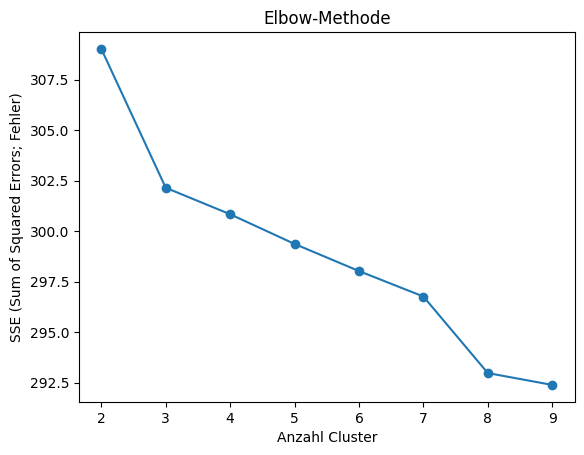

In [23]:
#Wie viele Cluster sind sinnvoll? (Elbow-Methode)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
K = range(2, 10)  # teste 2-9 Cluster

for k in K:
    km = KMeans(n_clusters=k, random_state=42) #Initialisiere KMeans
    km.fit(result) #Fitte KMeans auf die TF-IDF-Matrix
    sse.append(km.inertia_) #SSE (Sum of Squared Errors) speichern

plt.plot(K, sse, '-o') #Elbow-Kurve plotten
plt.xlabel("Anzahl Cluster")
plt.ylabel("SSE (Sum of Squared Errors; Fehler)")
plt.title("Elbow-Methode")
plt.show()

In [24]:
#Clustering mittels k-means
from sklearn.cluster import KMeans

#KMeans Clustering
k = 3  # Anzahl Cluster
model = KMeans(n_clusters=k, random_state=42) #Initialisiere KMeans
model.fit(result) #Fitte KMeans auf die TF-IDF-Matrix

#Cluster-Zuordnung pro Dokument
labels = model.labels_

for i, (doc, label) in enumerate(zip(posts_clean, labels)):
    print(f"[Cluster {label}] {doc}")

[Cluster 2] der stadt der feuer der dsa_names dunkel breiten sich der sehr tief wasser der bis an der horizont in fern norden der himmel berühren trag schlagen der welle an der ufer an der sich der schilf in sanft wind wiest in der weit ferne in glitzernd wasser ragen majestätisch ein schwarz berg aus der welle und weiß rauch steigen von sein spitze auf fern und doch unheimlich der sein cealan der verwunschen insel der jeder schiffer meiden sanft hügel und wald mit gehöft und klein dorf dazwischen erstrecken sich der gegenüber ebenso weit in der süden und dazwischen verlaufen der schier endlos straße meile zwischen der geschäftig stadt dsa_names in osten und der verschlafen groß marktdorf olat mit sein grafenburg olat fest an rand der riesig nebelmoor in westen davon mehr als ein tagesmarsch und der hälfte davon mit der pferd und soweit erstrecken sich auch der dsa_names vieler sagen und mythos und sagen umranken der geheimnisvoll gegend neben der stel der 12götter häufig dsa_names dsa

In [25]:
#Welche Wörter charakterisieren jedes Cluster?
import numpy as np

words = tfidf.get_feature_names_out()
centers = model.cluster_centers_

for i in range(k):
    print(f"\nTop-Wörter Cluster {i}:")
    top_indices = centers[i].argsort()[::-1][:10]  #10 wichtigste Wörter
    print([words[idx] for idx in top_indices])


Top-Wörter Cluster 0:
['fragen', 'fragen magister', 'fragen runde', 'neugierig', 'löschen fragen', 'fragen gefährt', 'runde', 'fragen höflich', 'fragen neugierig', 'fragen rundheraus']

Top-Wörter Cluster 1:
['antworten', 'antworten ergänzen', 'antworten kurz', 'antworten nüchtern', 'nüchtern', 'ergänzen', 'löschen antworten', 'antworten ebenso', 'ebenso leise', 'versichern']

Top-Wörter Cluster 2:
['erklären', 'blicken', 'wenden', 'ergänzen', 'entgegnen', 'gehen', 'elf', 'magister', 'erkundigen', 'sprechen']


In [32]:
#Wichtigsten Wörter die den Thread beschreiben
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(
    stop_words=german_stopwords,
    ngram_range=(1, 2)
)

tfidf_matrix = vectorizer.fit_transform(posts_clean)

feature_names = np.array(vectorizer.get_feature_names_out())

# Mittelwert der TF-IDF-Werte über alle Posts im Thread
mean_tfidf = tfidf_matrix.mean(axis=0).A1

top_n = 20
top_indices = mean_tfidf.argsort()[::-1][:top_n]

top_words = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

list(zip(top_words, top_scores))

[('antworten', np.float64(0.030248979009377747)),
 ('fragen', np.float64(0.026573543679662866)),
 ('erklären', np.float64(0.0254081059376697)),
 ('blicken', np.float64(0.01560904067784705)),
 ('ergänzen', np.float64(0.014067399712135338)),
 ('wenden', np.float64(0.0135155282281995)),
 ('magister', np.float64(0.012695628377906635)),
 ('elf', np.float64(0.01186659155299783)),
 ('entgegnen', np.float64(0.011405949861518374)),
 ('löschen', np.float64(0.011345433074476977)),
 ('gehen', np.float64(0.010942134501801218)),
 ('erkundigen', np.float64(0.010474206294076189)),
 ('sprechen', np.float64(0.009471711537542813)),
 ('kurz', np.float64(0.009062648864671192)),
 ('ja', np.float64(0.008972426103741358)),
 ('hören', np.float64(0.00896763237421115)),
 ('sagen', np.float64(0.008910005837353914)),
 ('see', np.float64(0.008785227468400077)),
 ('alt', np.float64(0.008550259365909016)),
 ('dan', np.float64(0.008532705329722173))]

In [33]:
", ".join(top_words[:10])

'antworten, fragen, erklären, blicken, ergänzen, wenden, magister, elf, entgegnen, löschen'

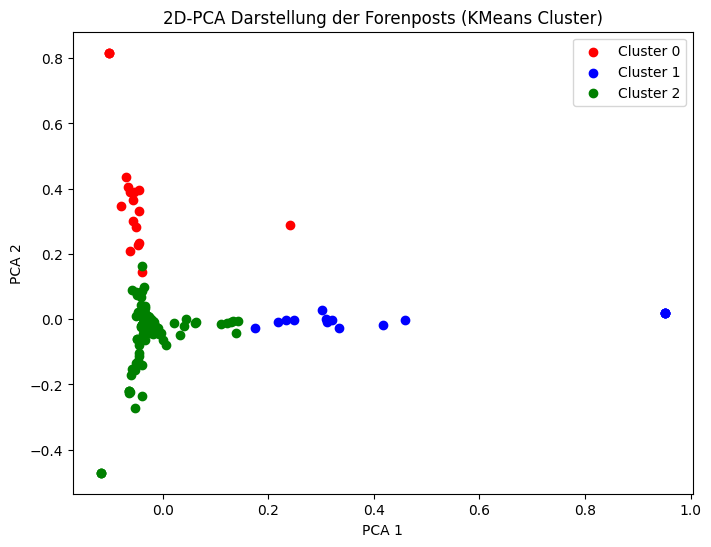

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA zur 2D-Visualisierung
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(result.toarray())

# Cluster-Farben
colors = ['red', 'blue', 'green', 'pink', 'black', 'orange', 'grey'] #, 'black', 'orange', 'grey'

plt.figure(figsize=(8, 6))
for i in range(k):
    points = tfidf_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("2D-PCA Darstellung der Forenposts (KMeans Cluster)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


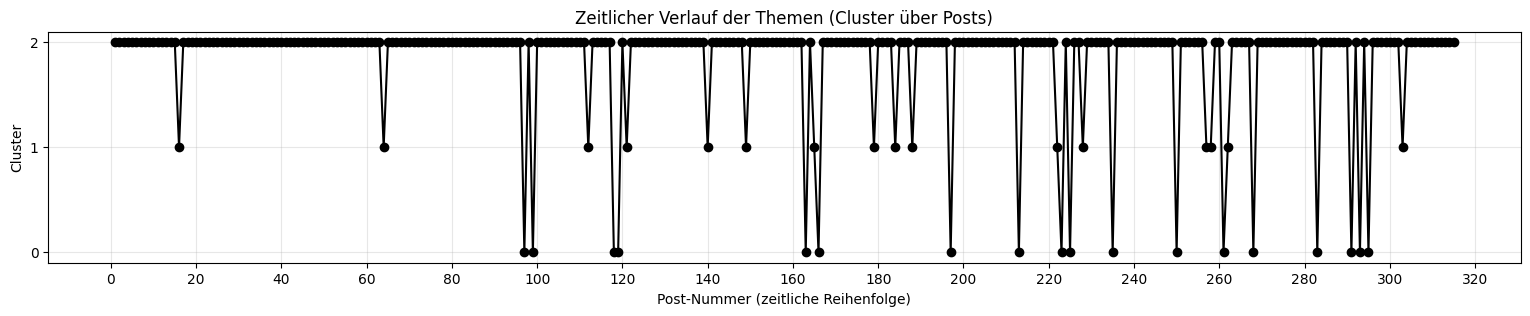

In [29]:
import matplotlib.ticker as ticker

plt.figure(figsize=(19, 3))
plt.plot(range(1, len(labels)+1), labels, marker='o', linestyle='-', color='black')

# Maximal 20 Ticks auf der X-Achse
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.yticks(sorted(set(labels)))
plt.xlabel("Post-Nummer (zeitliche Reihenfolge)")
plt.ylabel("Cluster")
plt.title("Zeitlicher Verlauf der Themen (Cluster über Posts)")

plt.grid(True, alpha=0.3)
plt.show()


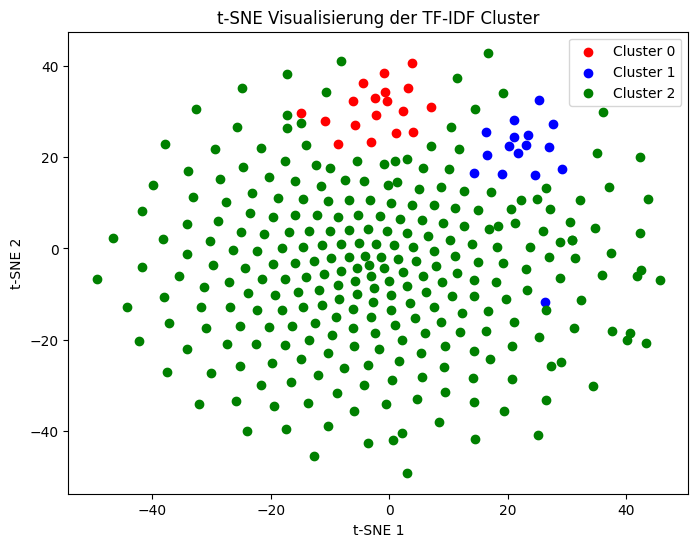

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE erzeugen (2 Dimensionen)
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tfidf_tsne = tsne.fit_transform(result.toarray())

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', "yellow", 'black', 'orange', 'grey']

for i in range(k):
    pts = tfidf_tsne[labels == i]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("t-SNE Visualisierung der TF-IDF Cluster")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


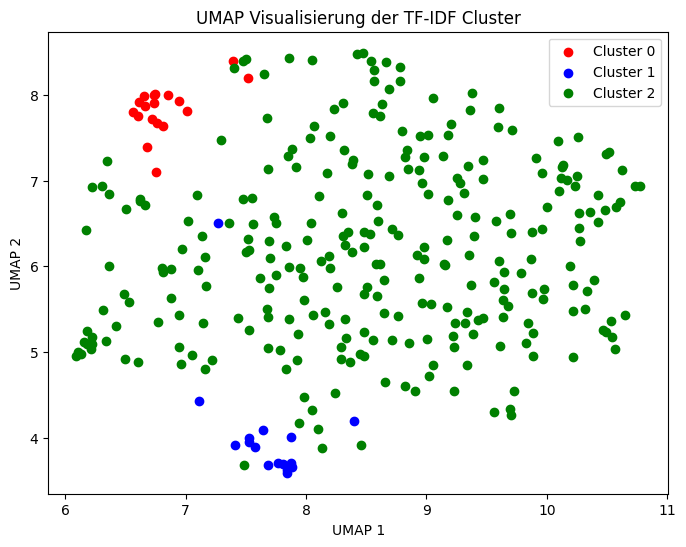

In [34]:
import umap
import matplotlib.pyplot as plt

# UMAP erzeugen
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'yellow', 'black', 'orange', 'grey']

for i in range(k):
    pts = tfidf_umap[labels == i]
    plt.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")

plt.title("UMAP Visualisierung der TF-IDF Cluster")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


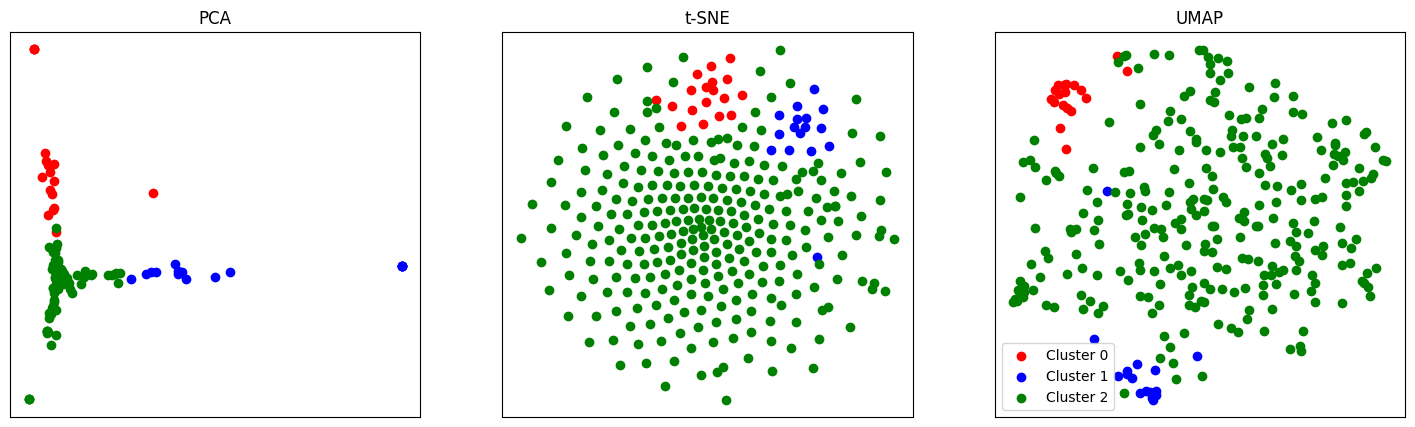

In [35]:
# PCA zur 2D-Visualisierung
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(result.toarray())

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

methods = {
    "PCA": tfidf_2d,
    "t-SNE": tfidf_tsne,
    "UMAP": tfidf_umap
}

for ax, (name, emb) in zip(axs, methods.items()):
    for i in range(k):
        pts = emb[labels == i]
        ax.scatter(pts[:, 0], pts[:, 1], c=colors[i], label=f"Cluster {i}")
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.legend()
plt.show()


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


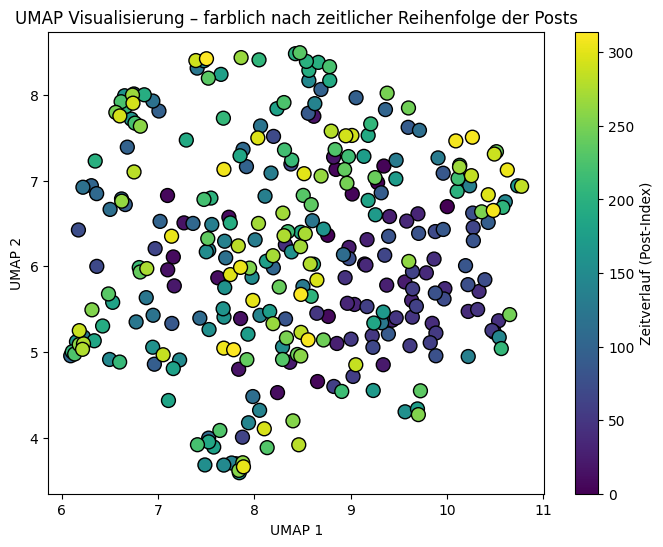

In [36]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# UMAP berechnen (2D)
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Zeitindex = einfach die Reihenfolge 0,1,2,... der Dokumente
time_index = np.arange(len(posts))

plt.figure(figsize=(8, 6))

# Scatterplot: Farbe = Zeitverlauf
scatter = plt.scatter(
    tfidf_umap[:, 0],
    tfidf_umap[:, 1],
    c=time_index,
    cmap="viridis",
    s=100,
    edgecolors='black'
)

plt.colorbar(scatter, label="Zeitverlauf (Post-Index)")
plt.title("UMAP Visualisierung – farblich nach zeitlicher Reihenfolge der Posts")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.show()


In [166]:
import umap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# ----------------------------
#  1. UMAP berechnen
# ----------------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
tfidf_umap = umap_model.fit_transform(result.toarray())

# Zeitindex = Reihenfolge der Posts
time_index = np.arange(len(posts))

# ----------------------------
#  2. Animation vorbereiten
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Hintergrundpunkte anzeigen
ax.scatter(tfidf_umap[:, 0], tfidf_umap[:, 1], c='lightgray', s=50)

# Animierter Scatterplot (startet leer)
scatter = ax.scatter(
    [], [],
    c=[],                     # Farben werden dynamisch gesetzt
    cmap="viridis",
    s=120,
    edgecolors="black",
    vmin=time_index.min(),
    vmax=time_index.max()
)

ax.set_title("UMAP – Animierter zeitlicher Verlauf der Forenposts")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# ----------------------------
#  3. Update-Funktion
# ----------------------------
def update(frame):
    # Werte bis zum aktuellen Frame anzeigen
    current_x = tfidf_umap[:frame+1, 0]
    current_y = tfidf_umap[:frame+1, 1]

    scatter.set_offsets(np.c_[current_x, current_y])
    scatter.set_array(time_index[:frame+1])  # Farben nach Zeitverlauf

    return scatter,

# ----------------------------
#  4. Animation erzeugen
# ----------------------------
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(posts),
    interval=800,
    repeat=False
)

# ----------------------------
#  5. Export als GIF
# ----------------------------
ani.save(
    "umap_timeline.gif",
    writer="imagemagick",
    dpi=120
)

# ----------------------------
#  6. Export als MP4
# ----------------------------
ani.save(
    "umap_timeline.mp4",
    writer="ffmpeg",
    fps=1   # 1 Frame pro Sekunde → 800ms wie Animation
)

plt.close(fig)   # Fenster schließen nach Export

print("GIF und MP4 erfolgreich gespeichert!")


/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
2025-11-27 21:23:39,810 - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-11-27 21:23:39,811 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2025-11-27 21:23:56,655 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-11-27 21:23:56,656 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x600 -pix_fmt rg

GIF und MP4 erfolgreich gespeichert!


_________________________

# tf-idf auf pos-tags

In [37]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
#pdf_folder = "../data/DSA/Der_blaue_Bruder"
pdf_folder = "../data/DSA/Die_Stadt_des_Feuers"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    time.sleep(0.5)
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))

Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Die_Stadt_des_Feuers/_combined.pdf
Lade die Datei lokal..



2026-01-25 23:17:12,038 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-25 23:17:12,057 - INFO - Going to convert document batch...
2026-01-25 23:17:12,058 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2026-01-25 23:17:12,060 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2026-01-25 23:17:12,060 - INFO - easyocr cannot be used because it is not installed.
2026-01-25 23:17:12,060 - INFO - Accelerator device: 'cuda:0'
[INFO] 2026-01-25 23:17:12,067 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2026-01-25 23:17:12,072 [RapidOCR] download_file.py:60: File exists and is valid: /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2026-01-25 23:17:12,072 [RapidOCR] torch.py:54: Using /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO


Anzahl Layout-Spans: 1626


In [38]:
from pipeline_preproc_pdf import process_doc_into_posts

#Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

#Posts ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

--- Post 1 ---
Die Stadt des Feuers Der Neunaugensee Dunkel breitet sich das sehr tiefe Wasser, das bis an den Horizont im fernen Norden den Himmel berührt. Träge schlagen die Wellen an das Ufer an dem  sich das Schilf im sanften Wind wiest. In der weiten Ferne im glitzernden Wasser ragt majestätisch ein schwarzer Berg aus den Wellen und weißer Rauch steigt von seiner Spitze auf. Fern und doch unheimlich. Das ist Cealan, die verwunschene Insel die jeder Schiffer meidet. Sanfte Hügel und Wälder mit Gehöften und kleinen Dörfern dazwischen erstrecken sich dem gegenüber  ebenso  weit in den Süden. Und dazwischen verläuft die schier endlose Straße 60  Meilen zwischen der geschäftigen Stadt Trallop im Osten und dem  verschlafenen größeren Markt-Dorf Olat mit seiner Grafenburg Olats Feste, am  Rande  des riesigen Nebelmoores im Westen davon. Mehr  als ein Tagesmarsch und die Hälfte davon mit dem  Pferd. Und soweit erstreckt sich auch der Neunaugensee. Viele Sagen und Mythen und Sagen umranken

In [42]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("de_core_news_lg")

reise_patterns = [
    # wanderte, wanderten, wanderst, wandert, etc.
    [{"LOWER": {"REGEX": "^wander"} , "POS": "VERB"}],

    # Lemma: reisen, ziehen, marschieren, durchqueren
    [{"LEMMA": {"IN": ["erreichen","reisen","ziehen","marschieren","durchqueren"]}, "POS": "VERB"}],

    # trennbares aufbrechen → brach ... auf
    [{"LEMMA": "brechen", "POS": "VERB"}, {"LOWER": "auf"}],

    # Nomen
    [{"LEMMA": {"IN": ["reise","weg","pfad","expedition","marsch"]}, "POS": "NOUN"}],
]

kampf_patterns = [
    [{"LEMMA": {"IN": ["kämpfen","angreifen","verteidigen","zuschlagen","stechen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["kampf","angriff","duell","schlacht","gegner","feind"]}, "POS": "NOUN"}]
]

ausruhen_patterns = [
    # ruhten
    [{"LEMMA": {"IN": ["ruhen","rasten","schlafen","lagern","entspannen"]}, "POS": "VERB"}],
    
    # ruhten ... aus  (trennbar!)
    [{"LEMMA": "ruhen"}, {"LOWER": "aus"}],

    # Nomen
    [{"LEMMA": {"IN": ["rast","pause","lager","ruhe","erholung"]}, "POS": "NOUN"}]
]

rettung_patterns = [
    [{"LEMMA": {"IN": ["retten","befreien","beschützen","opfern"]}, "POS": "VERB"}],
    [{"LOWER": {"IN": ["rettung","hilferuf","opfer","heldentat","gefahr","bedrohung"]}, "POS": "NOUN"}]
]

flucht_patterns = [
    # fliehen, entkommen, flüchten
    [{"LEMMA": {"IN": ["fliehen","entkommen","flüchten","verstecken"]}, "POS": "VERB"}],

    # trennbares wegrennen / rannte ... weg
    [{"LEMMA": "rennen", "POS": "VERB"}, {"LOWER": "weg"}],
    [{"LOWER": "weg"}, {"LEMMA": "rennen"}],

    [{"LEMMA": {"IN": ["flucht","unterschlupf","versteck","panik"]}, "POS": "NOUN"}]
]

training_patterns = [
    [{"LEMMA": {"IN": ["trainieren","üben","vorbereiten","meditieren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["training","übung","vorbereitung","lektion","technik"]}, "POS": "NOUN"}]
]

verfolgung_patterns = [
    [{"LEMMA": {"IN": ["verfolgen","jagen","suchen"]}, "POS": "VERB"}],
    [{"LEMMA": "spüren", "POS": "VERB"}, {"LOWER": "auf"}],
    [{"LEMMA": {"IN": ["verfolgung","jagd","spur","fährte"]}, "POS": "NOUN"}]
]

ruf_patterns = [
    [{"LEMMA": {"IN": ["rufen","einladen","beauftragen","verkünden","offenbaren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["ruf","auftrag","prophezeiung","vision","botschaft"]}, "POS": "NOUN"}]
]
belohnung_patterns = [
    [{"LEMMA": {"IN": ["belohnen","erkennen","verstehen","entdecken","gewinnen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["belohnung","schatz","erkenntnis","wahrheit","einsicht"]}, "POS": "NOUN"}]
]

categories = {
    "Reise": reise_patterns,
    "Kampf": kampf_patterns,
    "Ausruhen": ausruhen_patterns,
    "Rettung": rettung_patterns,
    "Flucht": flucht_patterns,
    "Training": training_patterns,
    "Verfolgung": verfolgung_patterns,
    "Ruf": ruf_patterns,
    "Belohnung": belohnung_patterns
}

# Matcher erstellen
matcher = Matcher(nlp.vocab)

# Patterns dem Matcher hinzufügen
for label, patterns in categories.items():
    matcher.add(label, patterns)

for post in posts:
    doc = nlp(post)
    matches = matcher(doc)
    #print(matches)

    # Ergebniscontainer
    category_hits = {c: [] for c in categories}

    
    #print("Kategorie:",category_hits)

    # Treffer zuordnen
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ausgabe
    for cat, hits in category_hits.items():
        if hits:
            #print("Post:",post)
            print(f"{cat}: {hits}")


Ruf: ['verkündet']
Ruf: ['verkündet']
Reise: ['wandert']
Ausruhen: ['entspannt']
Belohnung: ['erkennen']
Verfolgung: ['sucht']
Kampf: ['angreifen']
Flucht: ['verstecken']
Belohnung: ['erkennt']
Rettung: ['Gefahr']
Verfolgung: ['sucht']
Belohnung: ['erkennen']
Flucht: ['verstecken']
Verfolgung: ['jagen']
Verfolgung: ['sucht']
Reise: ['ziehen']
Ruf: ['verkündet']
Belohnung: ['verstehen']
Reise: ['gereist']
Ruf: ['verkündet']
Ruf: ['verkündet']
Ruf: ['verkündet']
Ruf: ['verkündet']
Rettung: ['beschützt']
Ruf: ['rufen', 'rufen']
Ruf: ['rufen']
Ruf: ['gerufen']
Ruf: ['rufen']
Ruf: ['rufen']
Belohnung: ['versteht']
Ruf: ['rief']
Reise: ['marschiert']
Rettung: ['beschützen', 'Gefahr']
Ruf: ['verkündet']
Kampf: ['verteidigt']
Belohnung: ['gewinnen']
Belohnung: ['verstehe']
Rettung: ['Gefahr']
Rettung: ['Gefahr']
Kampf: ['verteidigen']
Ruf: ['rufen']
Training: ['vorzubereiten']
Belohnung: ['erkennen']
Belohnung: ['verstehen']
Reise: ['ziehen']
Ruf: ['gerufen']
Belohnung: ['verstehen']
Ruf: ['ve

In [5]:
for post in posts:
    doc = nlp(post)
    matches = matcher(doc)

    hits = []

    # Alle Treffer extrahieren
    for match_id, start, end in matches:
        span = doc[start:end]
        hits.append(span.text)

    # Ausgabe nur der Treffer
    if hits:
        print(hits)


['ziehen', 'verfolgte', 'erreichte']
['verstehen', 'erkennen', 'suchen', 'sucht']
['suchte']
['erreicht']
['erreichen']
['gereist']
['entspannt', 'reisen']
['ruft']
['versteht', 'suchen']
['verstehen']
['verstehen']
['reise']
['ruht']
['versteht']
['suche']
['sucht']
['versteht', 'zieht']
['gereist']
['verstecken', 'gereist']
['zieht']
['suche']
['Opfer']
['suchen']
['suchen']
['suchen']
['suchen']
['suchen']
['zieht']
['sucht']
['verstehen']
['verstehe']
['zieht', 'erreicht']
['befreien', 'erreichen', 'suchen', 'erreichen']
['sucht']
['vorbereiten']
['verstanden']
['verstehe']
['erreichte']
['suchen']
['erkennt']
['entdeckt', 'erkennen', 'erkennen']
['fliehen']
['zieht', 'erkennen', 'reist']
['erkennt']
['entdecken']
['suchen']
['suchen']
['entdeckt', 'erkannt', 'suchen', 'sucht', 'erkennen']
['vorbereitet', 'ziehen']
['erkennen', 'verkündet']
['entdecken']
['ziehen']
['entdeckt']
['gewonnen']
['verstand', 'erkennen']
['sucht']
['ziehen']
['suchen', 'zieht', 'erkennen']
['sucht']
['zi

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

german_stopwords = stopwords.words('german') #Stopwords aus NLTK laden

newwords = ["ja", "wurde", "wäre", "setzt", "mal", "habt", "12", "10", "100", "1000", "11", "00", "02", "053", "1012", "14", "15", "16", "20", "200"]
german_stopwords.extend(newwords)

print(german_stopwords)

tfidf = TfidfVectorizer(stop_words=german_stopwords, max_df=0.95, min_df=1)
result = tfidf.fit_transform(hits)

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
import pandas as pd

words = tfidf.get_feature_names_out()
df = pd.DataFrame(result.toarray(), columns=words)
print(df)

--- 
# Übungen 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

d0 = 'Rausgewachsen: Weihnachtsbaum in Hameln ist zu groß für die Lichterkette'
d1 = 'Jahrelang verschollen: Vermisste Kugel mit Gin im Bodensee gefunden'
d2 = 'Propaganda-Pressekonferenz: Die alljährliche Putin-Show'
d3 = 'Machtkampf um Adenauer-Stiftung: Kramp-Karrenbauers Sieg ist Merz’ Niederlage'
d4 = 'Berichte in US-Medien: Trump trickst offenbar bei Finanzierung der »Kriegerdividende« für US-Militärs'
d5 = 'US-Weltraumpolitik: Trump legt Mondlandungen per Dekret fest'
string = [d0, d1, d2, d3, d4, d5]



In [21]:
from pipeline_preproc_lemma import TextPreprocessingPipeline #Posts von Satzzeichen und Ziffern bereinigen & anschließend lemmatisieren 

pipeline = TextPreprocessingPipeline()
string_clean = pipeline.process_posts(string, debug=False) #debug für print-Ausgaben der Zwischenschritte

Lade spaCy-Modell ...


In [22]:
for i in string_clean:
    print(i)

rausgewachsen weihnachtsbaum in hamel sein zu groß für der lichterkette
jahrelang verscholl vermis kugel mit gin in bodensee finden
propagandapressekonferenz der alljährlich putinshow
machtkampf um adenauerstiftung krampkarrenbauer sieg sein merz niederlage
bericht in usmedien trump trickst offenbar bei finanzierung der kriegerdividend für usmilitärs
usweltraumpolitik trump legen mondlandungen per dekret fest


In [33]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
result = tfidf.fit_transform(string_clean)

In [43]:
testout = tfidf.transform(string_clean)
type(testout)

scipy.sparse._csr.csr_matrix

In [34]:
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(ele1, ':', ele2)


idf values:
adenauerstiftung : 2.252762968495368
adenauerstiftung krampkarrenbauer : 2.252762968495368
alljährlich : 2.252762968495368
alljährlich putinshow : 2.252762968495368
bei : 2.252762968495368
bei finanzierung : 2.252762968495368
bericht : 2.252762968495368
bericht in : 2.252762968495368
bodensee : 2.252762968495368
bodensee finden : 2.252762968495368
dekret : 2.252762968495368
dekret fest : 2.252762968495368
der : 1.5596157879354227
der alljährlich : 2.252762968495368
der kriegerdividend : 2.252762968495368
der lichterkette : 2.252762968495368
fest : 2.252762968495368
finanzierung : 2.252762968495368
finanzierung der : 2.252762968495368
finden : 2.252762968495368
für : 1.8472978603872037
für der : 2.252762968495368
für usmilitärs : 2.252762968495368
gin : 2.252762968495368
gin in : 2.252762968495368
groß : 2.252762968495368
groß für : 2.252762968495368
hamel : 2.252762968495368
hamel sein : 2.252762968495368
in : 1.5596157879354227
in bodensee : 2.252762968495368
in hamel : 2

In [35]:
print('\nWord indexes:')
print(tfidf.vocabulary_)



Word indexes:
{'rausgewachsen': 60, 'weihnachtsbaum': 83, 'in': 29, 'hamel': 27, 'sein': 62, 'zu': 85, 'groß': 25, 'für': 20, 'der': 12, 'lichterkette': 43, 'rausgewachsen weihnachtsbaum': 61, 'weihnachtsbaum in': 84, 'in hamel': 31, 'hamel sein': 28, 'sein zu': 64, 'zu groß': 86, 'groß für': 26, 'für der': 21, 'der lichterkette': 15, 'jahrelang': 33, 'verscholl': 81, 'vermis': 79, 'kugel': 39, 'mit': 48, 'gin': 23, 'bodensee': 8, 'finden': 19, 'jahrelang verscholl': 34, 'verscholl vermis': 82, 'vermis kugel': 80, 'kugel mit': 40, 'mit gin': 49, 'gin in': 24, 'in bodensee': 30, 'bodensee finden': 9, 'propagandapressekonferenz': 57, 'alljährlich': 2, 'putinshow': 59, 'propagandapressekonferenz der': 58, 'der alljährlich': 13, 'alljährlich putinshow': 3, 'machtkampf': 44, 'um': 72, 'adenauerstiftung': 0, 'krampkarrenbauer': 35, 'sieg': 65, 'merz': 46, 'niederlage': 52, 'machtkampf um': 45, 'um adenauerstiftung': 73, 'adenauerstiftung krampkarrenbauer': 1, 'krampkarrenbauer sieg': 36, 's

In [36]:
print('\ntf-idf value:')
print(result)
print(type(result))


tf-idf value:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 94 stored elements and shape (6, 87)>
  Coords	Values
  (0, 60)	0.24039961928320974
  (0, 83)	0.24039961928320974
  (0, 29)	0.16643164278316291
  (0, 27)	0.24039961928320974
  (0, 62)	0.19713112677645864
  (0, 85)	0.24039961928320974
  (0, 25)	0.24039961928320974
  (0, 20)	0.19713112677645864
  (0, 12)	0.16643164278316291
  (0, 43)	0.24039961928320974
  (0, 61)	0.24039961928320974
  (0, 84)	0.24039961928320974
  (0, 31)	0.24039961928320974
  (0, 28)	0.24039961928320974
  (0, 64)	0.24039961928320974
  (0, 86)	0.24039961928320974
  (0, 26)	0.24039961928320974
  (0, 21)	0.24039961928320974
  (0, 15)	0.24039961928320974
  (1, 29)	0.17054256502911255
  (1, 33)	0.24633757751220312
  (1, 81)	0.24633757751220312
  (1, 79)	0.24633757751220312
  (1, 39)	0.24633757751220312
  (1, 48)	0.24633757751220312
  :	:
  (4, 76)	0.21665820080926318
  (4, 7)	0.21665820080926318
  (4, 32)	0.21665820080926318
  (4, 75)	0.216658200809

In [37]:
print('\ntf-idf values in matrix form:')
print(result.toarray())


tf-idf values in matrix form:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.16643164 0.         0.         0.24039962 0.         0.
  0.         0.         0.19713113 0.24039962 0.         0.
  0.         0.24039962 0.24039962 0.24039962 0.24039962 0.16643164
  0.         0.24039962 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.24039962 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.24039962 0.24039962 0.19713113 0.         0.24039962 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.24039962
  0.24039962 0.24039962 0.24039962]
 [0.         0.         0.         0.         0.         0.
  0.         0.  

In [38]:
import pandas as pd

words = tfidf.get_feature_names_out() #Wortliste aus dem Vokabular der TF-IDF-Matrix
df = pd.DataFrame(result.toarray(), columns=words) #DataFrame aus der TF-IDF-Matrix erstellen
print(df)

   adenauerstiftung  adenauerstiftung krampkarrenbauer  alljährlich  \
0          0.000000                           0.000000     0.000000   
1          0.000000                           0.000000     0.000000   
2          0.000000                           0.000000     0.392858   
3          0.261065                           0.261065     0.000000   
4          0.000000                           0.000000     0.000000   
5          0.000000                           0.000000     0.000000   

   alljährlich putinshow       bei  bei finanzierung   bericht  bericht in  \
0               0.000000  0.000000          0.000000  0.000000    0.000000   
1               0.000000  0.000000          0.000000  0.000000    0.000000   
2               0.392858  0.000000          0.000000  0.000000    0.000000   
3               0.000000  0.000000          0.000000  0.000000    0.000000   
4               0.000000  0.216658          0.216658  0.216658    0.216658   
5               0.000000  0.000000

In [39]:
#Wichtigste Wörter pro Post ausgeben
for i, doc in enumerate(string_clean):
    print(f"\n--- Wichtigste Wörter in Headline {i+1} ---")
    row = df.iloc[i]
    print(row.sort_values(ascending=False).head(7))


--- Wichtigste Wörter in Headline 1 ---
für der             0.2404
der lichterkette    0.2404
in hamel            0.2404
hamel               0.2404
hamel sein          0.2404
groß                0.2404
groß für            0.2404
Name: 0, dtype: float64

--- Wichtigste Wörter in Headline 2 ---
finden                 0.246338
bodensee finden        0.246338
bodensee               0.246338
jahrelang verscholl    0.246338
in bodensee            0.246338
gin in                 0.246338
gin                    0.246338
Name: 1, dtype: float64

--- Wichtigste Wörter in Headline 3 ---
alljährlich                      0.392858
alljährlich putinshow            0.392858
der alljährlich                  0.392858
putinshow                        0.392858
propagandapressekonferenz der    0.392858
propagandapressekonferenz        0.392858
der                              0.271981
Name: 2, dtype: float64

--- Wichtigste Wörter in Headline 4 ---
adenauerstiftung                     0.261065
adenauersti

In [19]:
#Wichtigste Wörter pro Post ausgeben
for i, doc in enumerate(string):
    print(f"\n--- Wichtigste Wörter in Headline {i+1} ---")
    row = df.iloc[i]
    print(row.sort_values(ascending=False).head(7))



--- Wichtigste Wörter in Headline 1 ---
groß              0.339233
hameln            0.339233
rausgewachsen     0.339233
zu                0.339233
weihnachtsbaum    0.339233
lichterkette      0.339233
für               0.278176
Name: 0, dtype: float64

--- Wichtigste Wörter in Headline 2 ---
im             0.333333
bodensee       0.333333
gin            0.333333
gefunden       0.333333
kugel          0.333333
vermisste      0.333333
verschollen    0.333333
Name: 1, dtype: float64

--- Wichtigste Wörter in Headline 3 ---
alljährliche       0.419871
show               0.419871
pressekonferenz    0.419871
propaganda         0.419871
putin              0.419871
die                0.344300
adenauer           0.000000
Name: 2, dtype: float64

--- Wichtigste Wörter in Headline 4 ---
adenauer        0.321538
karrenbauers    0.321538
stiftung        0.321538
sieg            0.321538
um              0.321538
niederlage      0.321538
merz            0.321538
Name: 3, dtype: float64

--- Wichtig

---

# Classification of text documents using sparse features (scikit learn)
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

In [1]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names


In [2]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.141s at 28.186MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.092s at 31.111MB/s
n_samples: 1353, n_features: 7831


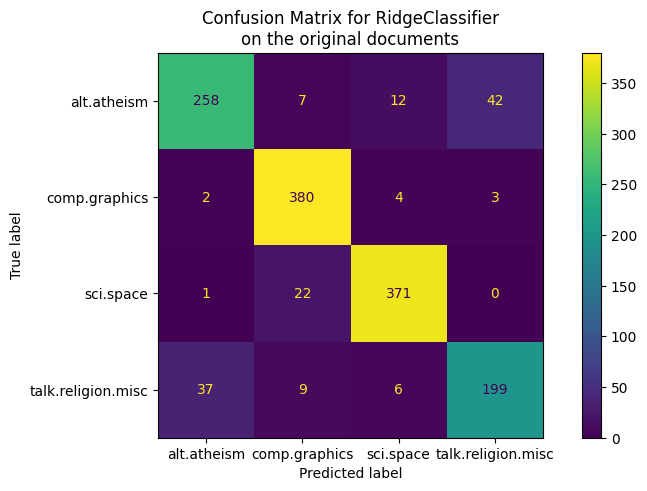

In [3]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


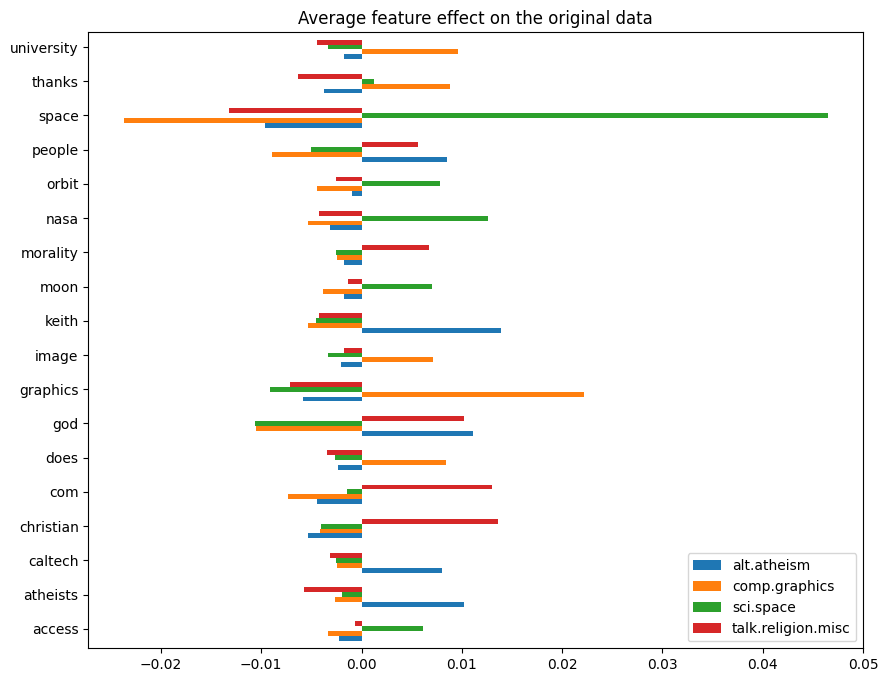

In [4]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")